In [27]:
from scipy import stats
import spacy
import wmd
import math
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
from nltk import bigrams, trigrams, pos_tag

# Lecture des données et instanciation du modèle

In [19]:
metrics_df=pd.read_csv('metrics.csv')

In [20]:
# Entrainement d'un apprentissage
model = SGDRegressor()
Y= list(metrics_df["score_humain"])

1. Essai avec toutes les métriques

In [5]:
#vectors=[list(a) for a in zip(metrics_df["model"],metrics_df["ibm1"],metrics_df["bleu"],metrics_df["meteor"],metrics_df["cos"])] 

# corrélation 0,61

2. Essai sans le cosinus (pour voir qu'il est vraiment indispensable)

In [6]:
#vectors=[list(a) for a in zip(metrics_df["model"],metrics_df["ibm1"],metrics_df["bleu"],metrics_df["meteor"])] 

# corrélation 0,09

3. Essai avec la différence de longueur des phrases

In [21]:
# essai avec différence de longueur des phrases

diff_length= [abs(len(d[0].split())-len(d[1].split()))/((len(d[0])+len(d[1]))/2) for d in zip(metrics_df["ref"],metrics_df["hyp"])]
metrics_df["diff_length"] = diff_length

#vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"])] 

# corrélation 0.61

4. Essai avec les bigrams et trigrams communs

In [22]:
# calcul des bi et trigrams communs
common_bigrams = [0 for x in range(len(metrics_df["hyp"]))]
common_trigrams = [0 for x in range(len(metrics_df["hyp"]))]
for i, (hyp , ref) in enumerate(list(zip(metrics_df["hyp"],metrics_df["ref"]))):
    common_grams_buffer = 0
    hyp_bigrams = list(bigrams(hyp.split()))
    ref_bigrams = list(bigrams(ref.split()))
    for bigram in hyp_bigrams : 
        if bigram in ref_bigrams :
            common_grams_buffer+=1
    common_bigrams[i] = common_grams_buffer/max(len(hyp_bigrams),1)

    common_grams_buffer = 0
    hyp_trigrams = list(trigrams(hyp.split()))
    ref_trigrams = list(trigrams(ref.split()))
    for trigram in hyp_trigrams :
        if trigram in ref_trigrams :
            common_grams_buffer+=1
    common_trigrams[i] = common_grams_buffer/max(len(hyp_trigrams),1)

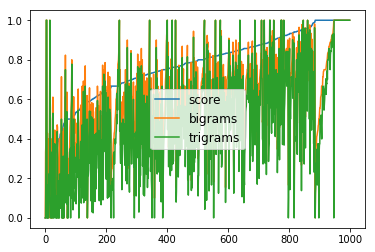

In [23]:
# graphique qui montre le rapport entre les ngrams communs et le score
fig = plt.figure()

x = [x for x in range(len(common_bigrams))]

values = sorted(list(zip(metrics_df["score_humain"],common_bigrams,common_trigrams)))
score = [ a for a,b,c in values]
bigrams = [ b for a,b,c in values]
trigrams = [ c for a,b,c in values]

plt.plot(x, score, label='score')
plt.plot(x, bigrams, label='bigrams')
plt.plot(x, trigrams, label='trigrams')

plt.legend(loc='center',fontsize=12)
plt.show()

In [24]:
metrics_df["bigrams"] = common_bigrams
metrics_df["trigrams"] = common_trigrams

# avec la différence de longueur
# vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"],metrics_df["trigrams"])] 
# corrélation 0.642

# sans la différence de longueur
# vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["bigrams"], metrics_df["trigrams"])] 
# corrélation 0.642


5. Essai avec les bigrams et trigrams de POS communs

In [28]:
# calcul des bi et trigrams de PoS communs
common_POSbigrams = [0 for x in range(len(metrics_df["hyp"]))]
common_POStrigrams = [0 for x in range(len(metrics_df["hyp"]))]
for i, (hyp , ref) in enumerate(list(zip(metrics_df["hyp"],metrics_df["ref"]))):
    common_POSgrams_buffer = 0
    hyp_POSbigrams = list(bigrams([pos for mot,pos in pos_tag(hyp.split())]))
    ref_POSbigrams = list(bigrams([pos for mot,pos in pos_tag(ref.split())]))
    for bigram in hyp_POSbigrams : 
        if bigram in ref_POSbigrams :
            common_POSgrams_buffer+=1
    common_POSbigrams[i] = common_POSgrams_buffer/max(len(hyp_POSbigrams),1)

    common_POSgrams_buffer = 0
    hyp_POStrigrams = list(trigrams([pos for mot,pos in pos_tag(hyp.split())]))
    ref_POStrigrams = list(trigrams([pos for mot,pos in pos_tag(ref.split())]))
    for trigram in hyp_POStrigrams :
        if trigram in ref_POStrigrams :
            common_POSgrams_buffer+=1
    common_POStrigrams[i] = common_POSgrams_buffer/max(len(hyp_POStrigrams),1)

In [29]:
metrics_df["POSbigrams"] = common_POSbigrams
metrics_df["POStrigrams"] = common_POStrigrams

# avec bigrams et trigrams de pos
# vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"], metrics_df["trigrams"],metrics_df["POSbigrams"],metrics_df["POStrigrams"])] 
# corrélation 0.636

# uniquement avec trigrams
# vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"], metrics_df["trigrams"],metrics_df["POStrigrams"])] 
# corrélation 0.645

# uniquement avec bigrams
# vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"], metrics_df["trigrams"],metrics_df["POSbigrams"])] 
# corrélation 0.648

6. Essai avec la similarité wmd

In [30]:
nlp = spacy.load('fr_core_news_md',create_pipeline=wmd.WMD.create_spacy_pipeline)
#on retire des stopwords certains mots afin qu'on n'obtienne pas de phrases vides
nlp.vocab["assez"].is_stop = False
nlp.vocab["Assez"].is_stop = False
nlp.vocab["Waouh"].is_stop = False
nlp.vocab["waouh"].is_stop = False

In [31]:
def wmd_(paire) :
    doc1 = nlp(paire[0])
    doc2 = nlp(paire[1])
    res=doc1.similarity(doc2)
    return res

In [32]:
wmd=[]
for i in range(len(metrics_df["hyp"])) :
    wmd.append(wmd_([metrics_df["hyp"][i],metrics_df["ref"][i]]))

In [33]:
# avec similarité cos,différence de longueur, bigrams, trigrams, bigramsPOS
#et ajout de similarité wmd
vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"], metrics_df["trigrams"],metrics_df["POSbigrams"],wmd)]

# corrélation 0.649

7. Essai de comparaison des embeddings de la source et de l'hypothèse

In [14]:
fr = spacy.load('fr_core_news_sm')
en = spacy.load('en_core_web_sm')

In [76]:
from sklearn.manifold import TSNE

src_hyp = []
ref_score = []

for i,instance in enumerate(list(zip(metrics_df["src"],metrics_df["hyp"],metrics_df['score_humain']))):
    print(i) #pour patienter et voir commment ça avance
    
    # on trouve et transforme l'embedding de la source
    src_words = np.array([w.vector for w in en(instance[0])])
    english_embedded = TSNE().fit_transform(src_words)
    emean = np.mean(english_embedded, axis=0)

    # on trouve et transforme l'embedding de l'hypothèse
    hyp_words = np.array([w.vector for w in fr(instance[1])])
    french_embedded = TSNE().fit_transform(hyp_words)
    fmean = np.mean(french_embedded, axis=0)

    # on calcule la similarité entre les deux
    simcos = np.dot(emean,fmean) / (np.linalg.norm(emean) * np.linalg.norm(fmean))
    
    # on enregistre cette similarité
    if(simcos>=-1 and simcos <=1):
        src_hyp.append(simcos)
    else: 
        src_hyp.append(0) # pour pas qu'il y ait de NaN si la phrase a moins de 2 mots
    ref_score.append(instance[2])



0
-0.84161365
1
0.91209114
2
-0.8287866
3
-0.6092892
4
-0.5337171
5
-0.23090063
6
0.9949405
7
0.5228331
8
0.82193273
9
0.008448941
10
0.43506417
11
-0.7201008
12
-0.9577462
13
0.13604689
14
0.689331
15
0.6655994
16
-0.2907593
17
0.47975662
18
0.79694134
19
0.9834526
20
-0.15999405
21
-0.74405324
22
0.28615788
23
0.9723783
24
-0.45452064
25
0.8129579
26
0.70476973
27
-0.8692345
28
0.14282987
29
0.8190499
30
0.9130369
31
0.67021614
32
0.58710897
33
-0.9260419
34
0.4957953
35
-0.9294278
36
0.7797771
37
0.87016606
38
0.055453457
39
-0.8861796
40
-0.4778202
41
0.6316263
42
0.9424093
43
-0.88981235
44
-0.3187053
45
0.98242235
46
-0.7525566
47
-0.09500215
48
-0.9967279
49
-0.5885282
50
-0.9980384
51
0.453535
52
0.13484348
53
0.74167025
54
-0.6667592
55
0.08247807
56
0.73980576
57
-0.8354562
58
-0.99687177
59
-0.40116647
60
-0.8167157
61
-0.549816
62
0.9151906
63
0.60085773
64
0.082733385
65
0.9999863
66
-0.24113601
67
-0.6923602
68
-0.8004122
69
-0.969786
70
0.84172666
71
-0.97371703
72
0.969

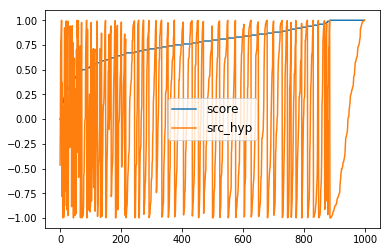

In [84]:
# graphique qui montre le rapport entre les cos src hyp et le score
fig = plt.figure()

x = [x for x in range(len(ref_score))]

values = sorted(list(zip(ref_score,src_hyp)))
score = [ a for a,b in values]
src_hyp = [ b for a,b in values]

plt.plot(x, score, label='score')
plt.plot(x, src_hyp, label='src_hyp')

plt.legend(loc='center',fontsize=12)
plt.show()

""" 8. Entrainement du model et évaluation des compétences """

In [38]:
# les caractéristiques finalement retenues pour le vecteur à donner en apprentissage
vectors=[list(a) for a in zip(metrics_df["cos"],metrics_df["diff_length"],metrics_df["bigrams"], metrics_df["trigrams"],metrics_df["POSbigrams"])]

# Séparation ensemble d'apprentissage et de test
m = int(len(Y)*0.8)
Y_train = Y[:m]
train_vectors = vectors[:m]
Y_test = Y[m:]
test_vectors = vectors[m:]

In [39]:
# Entrainement et prédictions avec le modèle
model.fit(train_vectors,Y_train)
predictions = model.predict(test_vectors)

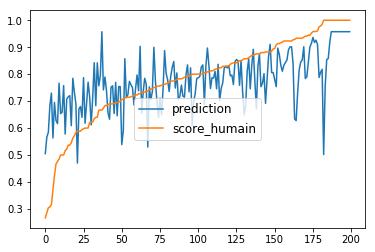

In [40]:
# Représentation graphique des performances du modèle
fig = plt.figure()

x = [x for x in range(len(predictions))]

values = sorted(list(zip(Y_test,predictions)))
pred = [ b for a,b in values]
y = [ a for a,b in values]

plt.plot(x, pred, label='prediction')
plt.plot(x, y, label='score_humain')

plt.legend(loc='center',fontsize=12)
plt.show()


10. Mesure de la corrélation obtenue avec le modèle

In [41]:
print(stats.spearmanr(predictions,Y_test))

SpearmanrResult(correlation=0.6474239835133482, pvalue=3.8077466391016267e-25)
